In [2]:
# =========================
# 1. KẾT NỐI GOOGLE DRIVE
# =========================
from google.colab import drive

# Kết nối với Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Đường dẫn tới file zip trong Google Drive
zip_path = '/content/drive/MyDrive/datasets/archive.zip'

# Thư mục giải nén ra
extract_path = '/content/FER_CNN_LSTM/dataset'

# Tạo thư mục nếu chưa có
os.makedirs(extract_path, exist_ok=True)

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Giải nén hoàn tất! Kiểm tra thư mục:", extract_path)


 Giải nén hoàn tất! Kiểm tra thư mục: /content/FER_CNN_LSTM/dataset


In [8]:
import os
from collections import defaultdict

def count_images_by_class(folder_path):
    class_counts = defaultdict(int)
    total_images = 0

    for class_name in sorted(os.listdir(folder_path)):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([
                f for f in os.listdir(class_folder)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            class_counts[class_name] = num_images
            total_images += num_images

    return total_images, class_counts

# Đường dẫn đến thư mục chứa các thư mục cảm xúc
dataset_path = '/content/FER_CNN_LSTM/dataset'

# Đếm và in kết quả
total_images, emotion_counts = count_images_by_class(dataset_path)

print(f"\n Tổng số ảnh trong bộ CK+: {total_images}")
for emotion, count in emotion_counts.items():
    print(f" - {emotion}: {count} ảnh")



 Tổng số ảnh trong bộ CK+: 981
 - anger: 135 ảnh
 - contempt: 54 ảnh
 - disgust: 177 ảnh
 - fear: 75 ảnh
 - happy: 207 ảnh
 - sadness: 84 ảnh
 - surprise: 249 ảnh


In [9]:
# =========================
# 2. CÀI ĐẶT THƯ VIỆN
# =========================
!pip install tensorflow opencv-python matplotlib seaborn

In [10]:
# =========================
# 3. IMPORT THƯ VIỆN
# =========================
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     LSTM, TimeDistributed, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
import os
import glob
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# =========================
# 4. CẤU HÌNH BAN ĐẦU
# =========================
IMG_SIZE = 48
NUM_CLASSES = 7
NUM_FRAMES = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)
SEQ_SHAPE = (NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)
BATCH_SIZE = 64
EPOCHS = 120
LEARNING_RATE = 0.001

# =========================
# 5. LOAD DỮ LIỆU
# =========================
def load_ckplus_data(data_path, img_size=48):
    images = []
    labels = []
    label_names = sorted(os.listdir(data_path))

    for label in label_names:
        class_path = os.path.join(data_path, label)
        if not os.path.isdir(class_path):
            continue
        img_files = glob.glob(os.path.join(class_path, '*.jpg')) + glob.glob(os.path.join(class_path, '*.png'))
        for file in img_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# =========================
# GỌI HÀM LOAD DỮ LIỆU
# =========================
dataset_path = '/content/FER_CNN_LSTM/dataset'
X_all, y_all = load_ckplus_data(dataset_path, img_size=IMG_SIZE)

# =========================
# MÃ HÓA NHÃN (LabelEncoder + One-hot)
# =========================
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)
NUM_CLASSES = len(label_encoder.classes_)  # Cập nhật lại nếu số nhãn khác 7

y_all_cat = to_categorical(y_all_encoded, num_classes=NUM_CLASSES)

# =========================
# THÊM KÊNH MÀU CHO ẢNH
# =========================
X_all = np.expand_dims(X_all, axis=-1)  # (samples, 48, 48, 1)

# =========================
# CHIA TRAIN/TEST 80:20
# =========================
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X_all, y_all_cat, test_size=0.2, random_state=42, stratify=y_all_encoded
)

# =========================
# CHUYỂN THÀNH CHUỖI CHO LSTM
# =========================
def reshape_to_sequence(X, y, num_frames, img_size, num_classes):
    n = (X.shape[0] // num_frames) * num_frames
    X = X[:n]
    y = y[:n]
    X_seq = X.reshape((-1, num_frames, img_size, img_size, 1))
    y_seq = y.reshape((-1, num_frames, num_classes))
    y_seq_last = y_seq[:, -1, :]  # lấy nhãn của frame cuối
    return X_seq, y_seq_last

X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES, IMG_SIZE, NUM_CLASSES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES, IMG_SIZE, NUM_CLASSES)


In [29]:
# =========================
# 6. XÂY DỰNG MÔ HÌNH CNN-LSTM
# =========================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     LSTM, TimeDistributed, BatchNormalization)
from tensorflow.keras.optimizers import Adam

# Khởi tạo mô hình tuần tự (Sequential)
model = Sequential()

# ----- BLOCK CNN 1 -----
# TimeDistributed áp dụng Conv2D cho từng frame trong chuỗi
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
                          input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))     # Giảm kích thước không gian
model.add(TimeDistributed(BatchNormalization()))     # Chuẩn hóa dữ liệu từng frame
model.add(TimeDistributed(Dropout(0.3)))             # Dropout để giảm overfitting

# ----- BLOCK CNN 2 -----
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Flatten()))                # Chuyển tensor 2D thành vector đặc trưng

# ----- LSTM -----
# Xử lý chuỗi vector đặc trưng theo thời gian
model.add(LSTM(128))           # 128 đơn vị nhớ
model.add(Dropout(0.5))        # Dropout tiếp theo để tránh overfitting

# ----- FULLY CONNECTED (Output) -----
model.add(Dense(NUM_CLASSES, activation='softmax'))  # Softmax để phân loại cảm xúc

# ----- BIÊN DỊCH MÔ HÌNH -----
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),   # Adam với learning rate đã định nghĩa
              loss='categorical_crossentropy',               # Dùng cho phân loại nhiều lớp
              metrics=['accuracy'])                          # Theo dõi độ chính xác trong training

# In cấu trúc mô hình
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_16             │ (None, 3, 46, 46, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 3, 23, 23, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 3, 23, 23, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 3, 23, 23, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 3, 21, 21, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 3, 10, 10, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 3, 10, 10, 64)  │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 3, 6400)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,362,951 (12.83 MB)

 Trainable params: 3,362,759 (12.83 MB)

 Non-trainable params: 192 (768.00 B)

In [30]:
# =========================
# 7. CHUẨN HÓA DỮ LIỆU ĐẦU VÀO DẠNG CHUỖI
# =========================

def reshape_to_sequence(X, y, num_frames):
    """
    Cắt dữ liệu để đảm bảo chia hết cho num_frames,
    sau đó reshape thành dạng chuỗi cho mô hình CNN-LSTM.
    """
    n = (X.shape[0] // num_frames) * num_frames  # Cắt bớt ảnh dư
    X = X[:n]
    y = y[:n]

    # Reshape ảnh thành chuỗi: (số chuỗi, num_frames, 48, 48, 1)
    X_seq = X.reshape((-1, num_frames, IMG_SIZE, IMG_SIZE, 1))

    # Reshape nhãn và lấy nhãn cuối mỗi chuỗi làm đại diện
    y_seq = y.reshape((-1, num_frames, NUM_CLASSES))
    y_seq_last = y_seq[:, -1, :]  # lấy nhãn frame cuối làm nhãn đại diện

    return X_seq, y_seq_last

# Gọi hàm chuẩn hóa chuỗi
X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES)

# In kiểm tra shape kết quả
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)


X_train_seq shape: (261, 3, 48, 48, 1)
y_train_seq shape: (261, 7)


In [31]:
# =========================
# 8. HUẤN LUYỆN VỚI CALLBACK LƯU MÔ HÌNH MỖI 5 EPOCH
# =========================

from tensorflow.keras.callbacks import ModelCheckpoint

# Đường dẫn lưu mô hình (Google Drive)
checkpoint_dir = '/content/drive/MyDrive/FER_CNN_LSTM/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback: Lưu mô hình mỗi 5 epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),  # Tên file theo epoch
    save_weights_only=False,   # Lưu cả mô hình, không chỉ weights
    save_freq='epoch',         # Lưu theo mỗi epoch, ta kiểm tra bên trong để chỉ giữ lại mỗi 5 epoch nếu muốn
    verbose=1
)

# Callback: Lưu lịch sử huấn luyện (có thể thêm EarlyStopping hoặc ReduceLROnPlateau nếu cần)

# Huấn luyện mô hình
history = model.fit(
    X_train_seq, y_train_seq,                               # Dữ liệu huấn luyện
    validation_data=(X_test_seq, y_test_seq),               # Dữ liệu kiểm thử
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback],                        # Danh sách callback
    verbose=1
)


Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2894 - loss: 1.8648
Epoch 1: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_01.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 643ms/step - accuracy: 0.2954 - loss: 1.8637 - val_accuracy: 0.2308 - val_loss: 1.8694
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4950 - loss: 1.3582
Epoch 2: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_02.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.4936 - loss: 1.3676 - val_accuracy: 0.1077 - val_loss: 2.1071
Epoch 3/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5660 - loss: 1.2387 
Epoch 3: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_03.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.5882 - loss: 1.1917 - val_accuracy: 0.1077 - val_loss: 2.4527
Epoch 4/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6727 - loss: 1.0635 
Epoch 4: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_04.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.6712 - loss: 1.0372 - val_accuracy: 0.1077 - val_loss: 2.6845
Epoch 5/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7335 - loss: 0.8608 
Epoch 5: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_05.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.7401 - loss: 0.8537 - val_accuracy: 0.1077 - val_loss: 2.8350
Epoch 6/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7830 - loss: 0.7134
Epoch 6: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_06.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7795 - loss: 0.7189 - val_accuracy: 0.1077 - val_loss: 2.8262
Epoch 7/120
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7839 - loss: 0.7485
Epoch 7: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_07.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - accuracy: 0.7844 - loss: 0.7474 - val_accuracy: 0.1077 - val_loss: 2.6414
Epoch 8/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8698 - loss: 0.6257
Epoch 8: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_08.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.8494 - loss: 0.6340 - val_accuracy: 0.1077 - val_loss: 2.5594
Epoch 9/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8429 - loss: 0.5832
Epoch 9: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_09.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step - accuracy: 0.8321 - loss: 0.6055 - val_accuracy: 0.2769 - val_loss: 2.5830
Epoch 10/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8524 - loss: 0.5338
Epoch 10: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_10.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 726ms/step - accuracy: 0.8515 - loss: 0.5381 - val_accuracy: 0.1077 - val_loss: 2.5980
Epoch 11/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8604 - loss: 0.5180
Epoch 11: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_11.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.8626 - loss: 0.5134 - val_accuracy: 0.1077 - val_loss: 2.5980
Epoch 12/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8853 - loss: 0.4437
Epoch 12: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_12.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.8891 - loss: 0.4389 - val_accuracy: 0.1077 - val_loss: 2.6256
Epoch 13/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8889 - loss: 0.4090
Epoch 13: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_13.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.8911 - loss: 0.4148 - val_accuracy: 0.1077 - val_loss: 2.8392
Epoch 14/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9282 - loss: 0.3342
Epoch 14: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_14.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - accuracy: 0.9267 - loss: 0.3360 - val_accuracy: 0.1077 - val_loss: 3.0174
Epoch 15/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9305 - loss: 0.3240
Epoch 15: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_15.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.9293 - loss: 0.3254 - val_accuracy: 0.1077 - val_loss: 2.8994
Epoch 16/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9372 - loss: 0.3190
Epoch 16: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_16.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 886ms/step - accuracy: 0.9381 - loss: 0.3172 - val_accuracy: 0.1077 - val_loss: 2.9542
Epoch 17/120
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9570 - loss: 0.2717
Epoch 17: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_17.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 0.9560 - loss: 0.2700 - val_accuracy: 0.1077 - val_loss: 2.9868
Epoch 18/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9559 - loss: 0.2582
Epoch 18: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_18.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 804ms/step - accuracy: 0.9568 - loss: 0.2563 - val_accuracy: 0.1077 - val_loss: 2.8651
Epoch 19/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9678 - loss: 0.2212
Epoch 19: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_19.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 569ms/step - accuracy: 0.9681 - loss: 0.2190 - val_accuracy: 0.1077 - val_loss: 2.9917
Epoch 20/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9844 - loss: 0.1910
Epoch 20: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_20.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.9774 - loss: 0.1947 - val_accuracy: 0.1077 - val_loss: 3.1337
Epoch 21/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9813 - loss: 0.1740
Epoch 21: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_21.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.9806 - loss: 0.1749 - val_accuracy: 0.1077 - val_loss: 3.0499
Epoch 22/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9948 - loss: 0.1608
Epoch 22: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_22.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.9944 - loss: 0.1616 - val_accuracy: 0.1077 - val_loss: 2.9841
Epoch 23/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9870 - loss: 0.1513
Epoch 23: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_23.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.9819 - loss: 0.1601 - val_accuracy: 0.1077 - val_loss: 2.9224
Epoch 24/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9679 - loss: 0.1431
Epoch 24: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_24.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.9685 - loss: 0.1502 - val_accuracy: 0.1077 - val_loss: 2.8959
Epoch 25/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9731 - loss: 0.1763
Epoch 25: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_25.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step - accuracy: 0.9756 - loss: 0.1689 - val_accuracy: 0.1077 - val_loss: 2.8479
Epoch 26/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9870 - loss: 0.1256
Epoch 26: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_26.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.9873 - loss: 0.1256 - val_accuracy: 0.1077 - val_loss: 2.7588
Epoch 27/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9886 - loss: 0.1358
Epoch 27: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_27.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.9879 - loss: 0.1357 - val_accuracy: 0.1231 - val_loss: 2.7325
Epoch 28/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9875 - loss: 0.1130
Epoch 28: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_28.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - accuracy: 0.9877 - loss: 0.1121 - val_accuracy: 0.1231 - val_loss: 2.7761
Epoch 29/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9861 - loss: 0.1086
Epoch 29: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_29.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.9873 - loss: 0.1047 - val_accuracy: 0.1077 - val_loss: 2.8640
Epoch 30/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.1054
Epoch 30: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_30.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 1.0000 - loss: 0.0991 - val_accuracy: 0.1077 - val_loss: 2.8877
Epoch 31/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0751
Epoch 31: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_31.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 1.0000 - loss: 0.0742 - val_accuracy: 0.1077 - val_loss: 2.7983
Epoch 32/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0674
Epoch 32: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_32.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step - accuracy: 1.0000 - loss: 0.0669 - val_accuracy: 0.1077 - val_loss: 2.7584
Epoch 33/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0828
Epoch 33: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_33.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 832ms/step - accuracy: 0.9981 - loss: 0.0872 - val_accuracy: 0.1077 - val_loss: 2.8021
Epoch 34/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0640
Epoch 34: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_34.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 1.0000 - loss: 0.0637 - val_accuracy: 0.1385 - val_loss: 2.7232
Epoch 35/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9958 - loss: 0.0575
Epoch 35: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_35.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step - accuracy: 0.9959 - loss: 0.0576 - val_accuracy: 0.1538 - val_loss: 2.6140
Epoch 36/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9983 - loss: 0.0614
Epoch 36: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_36.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.9972 - loss: 0.0625 - val_accuracy: 0.2000 - val_loss: 2.3881
Epoch 37/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0505
Epoch 37: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_37.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step - accuracy: 1.0000 - loss: 0.0508 - val_accuracy: 0.3231 - val_loss: 2.1909
Epoch 38/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0571
Epoch 38: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_38.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 883ms/step - accuracy: 1.0000 - loss: 0.0568 - val_accuracy: 0.3385 - val_loss: 2.0259
Epoch 39/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9905 - loss: 0.0486
Epoch 39: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_39.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.9933 - loss: 0.0489 - val_accuracy: 0.3231 - val_loss: 1.9607
Epoch 40/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0481
Epoch 40: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_40.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 1.0000 - loss: 0.0481 - val_accuracy: 0.3077 - val_loss: 1.8816
Epoch 41/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0424
Epoch 41: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_41.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 1.0000 - loss: 0.0428 - val_accuracy: 0.3692 - val_loss: 1.7039
Epoch 42/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0397
Epoch 42: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_42.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 0.4923 - val_loss: 1.3874
Epoch 43/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0342
Epoch 43: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_43.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 0.5846 - val_loss: 1.1169
Epoch 44/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0396
Epoch 44: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_44.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step - accuracy: 1.0000 - loss: 0.0395 - val_accuracy: 0.6769 - val_loss: 0.9644
Epoch 45/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0336
Epoch 45: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_45.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 874ms/step - accuracy: 1.0000 - loss: 0.0333 - val_accuracy: 0.7231 - val_loss: 0.8210
Epoch 46/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0296
Epoch 46: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_46.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - accuracy: 1.0000 - loss: 0.0297 - val_accuracy: 0.7538 - val_loss: 0.7434
Epoch 47/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0325
Epoch 47: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_47.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 1.0000 - loss: 0.0320 - val_accuracy: 0.7538 - val_loss: 0.7219
Epoch 48/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0326
Epoch 48: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_48.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step - accuracy: 1.0000 - loss: 0.0342 - val_accuracy: 0.7538 - val_loss: 0.7145
Epoch 49/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0259
Epoch 49: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_49.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 0.7538 - val_loss: 0.7057
Epoch 50/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0298
Epoch 50: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_50.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.7692 - val_loss: 0.6882
Epoch 51/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0249
Epoch 51: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_51.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 1.0000 - loss: 0.0245 - val_accuracy: 0.7846 - val_loss: 0.6413
Epoch 52/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0255
Epoch 52: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_52.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 1.0000 - loss: 0.0255 - val_accuracy: 0.7846 - val_loss: 0.6108
Epoch 53/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0206
Epoch 53: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_53.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0209 - val_accuracy: 0.7846 - val_loss: 0.5851
Epoch 54/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0239
Epoch 54: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_54.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 0.8000 - val_loss: 0.5457
Epoch 55/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0226 
Epoch 55: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_55.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.8462 - val_loss: 0.5156
Epoch 56/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0296
Epoch 56: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_56.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0290 - val_accuracy: 0.8462 - val_loss: 0.4540
Epoch 57/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0211 
Epoch 57: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_57.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.0232 - val_accuracy: 0.8769 - val_loss: 0.3727
Epoch 58/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0200
Epoch 58: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_58.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 1.0000 - loss: 0.0210 - val_accuracy: 0.9077 - val_loss: 0.3068
Epoch 59/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0262
Epoch 59: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_59.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 0.9077 - val_loss: 0.2953
Epoch 60/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0199
Epoch 60: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_60.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.9231 - val_loss: 0.3208
Epoch 61/120
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0283
Epoch 61: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_61.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 0.9077 - val_loss: 0.3605
Epoch 62/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0267
Epoch 62: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_62.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 1.0000 - loss: 0.0263 - val_accuracy: 0.8615 - val_loss: 0.4256
Epoch 63/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0353
Epoch 63: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_63.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 0.0350 - val_accuracy: 0.8615 - val_loss: 0.4146
Epoch 64/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0202
Epoch 64: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_64.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 1.0000 - loss: 0.0210 - val_accuracy: 0.8769 - val_loss: 0.3569
Epoch 65/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0284
Epoch 65: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_65.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 0.9231 - val_loss: 0.2999
Epoch 66/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0199
Epoch 66: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_66.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0206 - val_accuracy: 0.9231 - val_loss: 0.2692
Epoch 67/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0213
Epoch 67: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_67.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 0.9231 - val_loss: 0.2682
Epoch 68/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0202
Epoch 68: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_68.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 0.9077 - val_loss: 0.2663
Epoch 69/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0187
Epoch 69: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_69.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 0.9231 - val_loss: 0.2556
Epoch 70/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0145 
Epoch 70: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_70.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.9231 - val_loss: 0.2546
Epoch 71/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0136 
Epoch 71: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_71.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.9231 - val_loss: 0.2777
Epoch 72/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0140 
Epoch 72: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_72.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.9231 - val_loss: 0.2873
Epoch 73/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0204
Epoch 73: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_73.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.9231 - val_loss: 0.2772
Epoch 74/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0129
Epoch 74: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_74.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.9231 - val_loss: 0.2556
Epoch 75/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0093 
Epoch 75: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_75.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 0.9231 - val_loss: 0.2508
Epoch 76/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0189 
Epoch 76: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_76.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.9231 - val_loss: 0.2728
Epoch 77/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0115
Epoch 77: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_77.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9231 - val_loss: 0.2950
Epoch 78/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0129
Epoch 78: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_78.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 0.9231 - val_loss: 0.3016
Epoch 79/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0138
Epoch 79: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_79.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.9231 - val_loss: 0.2868
Epoch 80/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0103
Epoch 80: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_80.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.9231 - val_loss: 0.2861
Epoch 81/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0122
Epoch 81: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_81.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 0.9077 - val_loss: 0.3191
Epoch 82/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0121
Epoch 82: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_82.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9231 - val_loss: 0.3034
Epoch 83/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0118
Epoch 83: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_83.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.9231 - val_loss: 0.2767
Epoch 84/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0121
Epoch 84: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_84.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.9231 - val_loss: 0.2596
Epoch 85/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0128
Epoch 85: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_85.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 0.9231 - val_loss: 0.2527
Epoch 86/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0092 
Epoch 86: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_86.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 0.9385 - val_loss: 0.2498
Epoch 87/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0080
Epoch 87: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_87.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.9231 - val_loss: 0.2536
Epoch 88/120
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0087
Epoch 88: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_88.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.9231 - val_loss: 0.2836
Epoch 89/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0106
Epoch 89: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_89.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.9231 - val_loss: 0.2893
Epoch 90/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0106 
Epoch 90: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_90.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.9231 - val_loss: 0.2884
Epoch 91/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0107
Epoch 91: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_91.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.9231 - val_loss: 0.2808
Epoch 92/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0099
Epoch 92: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_92.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.9231 - val_loss: 0.2489
Epoch 93/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0107 
Epoch 93: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_93.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.9385 - val_loss: 0.2063
Epoch 94/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0075
Epoch 94: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_94.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9385 - val_loss: 0.2113
Epoch 95/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0112
Epoch 95: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_95.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.9077 - val_loss: 0.3432
Epoch 96/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9983 - loss: 0.0166 
Epoch 96: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_96.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9972 - loss: 0.0176 - val_accuracy: 0.8923 - val_loss: 0.3810
Epoch 97/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0210
Epoch 97: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_97.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.9231 - val_loss: 0.3179
Epoch 98/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0102
Epoch 98: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_98.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.9231 - val_loss: 0.2816
Epoch 99/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0123 
Epoch 99: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_99.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.9231 - val_loss: 0.2814
Epoch 100/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0118
Epoch 100: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_100.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9385 - val_loss: 0.2904
Epoch 101/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0097
Epoch 101: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_101.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9077 - val_loss: 0.3091
Epoch 102/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0122 
Epoch 102: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_102.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.9077 - val_loss: 0.3264
Epoch 103/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0079 
Epoch 103: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_103.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9077 - val_loss: 0.3096
Epoch 104/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 104: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_104.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9077 - val_loss: 0.2767
Epoch 105/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 105: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_105.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9077 - val_loss: 0.2555
Epoch 106/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 106: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_106.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9231 - val_loss: 0.2482
Epoch 107/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0074
Epoch 107: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_107.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9231 - val_loss: 0.2491
Epoch 108/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0093
Epoch 108: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_108.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.9231 - val_loss: 0.2397
Epoch 109/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0063
Epoch 109: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_109.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9231 - val_loss: 0.2471
Epoch 110/120
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 110: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_110.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9231 - val_loss: 0.2557
Epoch 111/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0052
Epoch 111: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_111.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9231 - val_loss: 0.2592
Epoch 112/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0098
Epoch 112: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_112.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.9385 - val_loss: 0.2554
Epoch 113/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0072
Epoch 113: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_113.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9231 - val_loss: 0.2627
Epoch 114/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0068 
Epoch 114: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_114.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9077 - val_loss: 0.3261
Epoch 115/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0086
Epoch 115: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_115.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8923 - val_loss: 0.3535
Epoch 116/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0105 
Epoch 116: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_116.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.9077 - val_loss: 0.3190
Epoch 117/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0088 
Epoch 117: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_117.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9231 - val_loss: 0.2659
Epoch 118/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0062
Epoch 118: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_118.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9077 - val_loss: 0.2443
Epoch 119/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0066 
Epoch 119: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_119.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.9077 - val_loss: 0.2433
Epoch 120/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0073 
Epoch 120: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_120.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9231 - val_loss: 0.2387


In [32]:
# =========================
# 9. ĐÁNH GIÁ MÔ HÌNH
# =========================

from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# 9.1 Dự đoán trên tập kiểm thử
# -------------------------
y_pred_probs = model.predict(X_test_seq)                                # Xác suất dự đoán
y_pred_classes = np.argmax(y_pred_probs, axis=1)                        # Lấy nhãn dự đoán (số)
y_true_classes = np.argmax(y_test_seq, axis=1)                          # Lấy nhãn thật (số)

# -------------------------
# 9.2 Báo cáo độ chính xác, Precision, Recall, F1-Score
# -------------------------
print("=== Classification Report ===")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       anger       1.00      0.88      0.93         8
    contempt       0.64      1.00      0.78         7
     disgust       1.00      1.00      1.00        14
        fear       1.00      0.71      0.83         7
       happy       1.00      1.00      1.00        12
     sadness       0.80      0.80      0.80         5
    surprise       1.00      0.92      0.96        12

    accuracy                           0.92        65
   macro avg       0.92      0.90      0.90        65
weighted avg       0.95      0.92      0.93        65



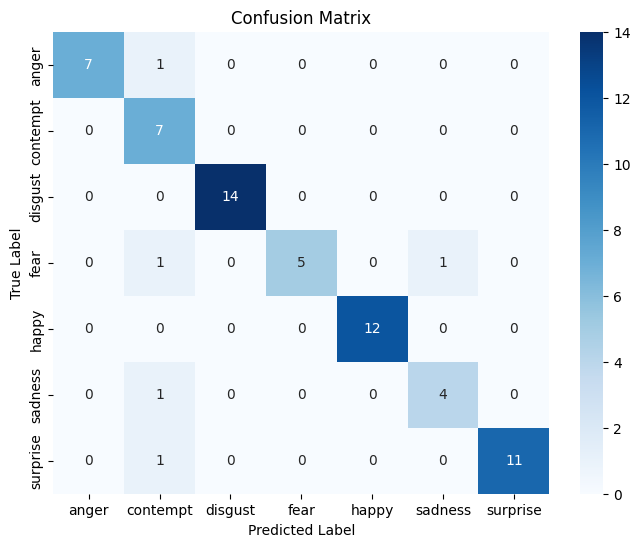

In [33]:
# -------------------------
# 9.3 Ma trận nhầm lẫn
# -------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


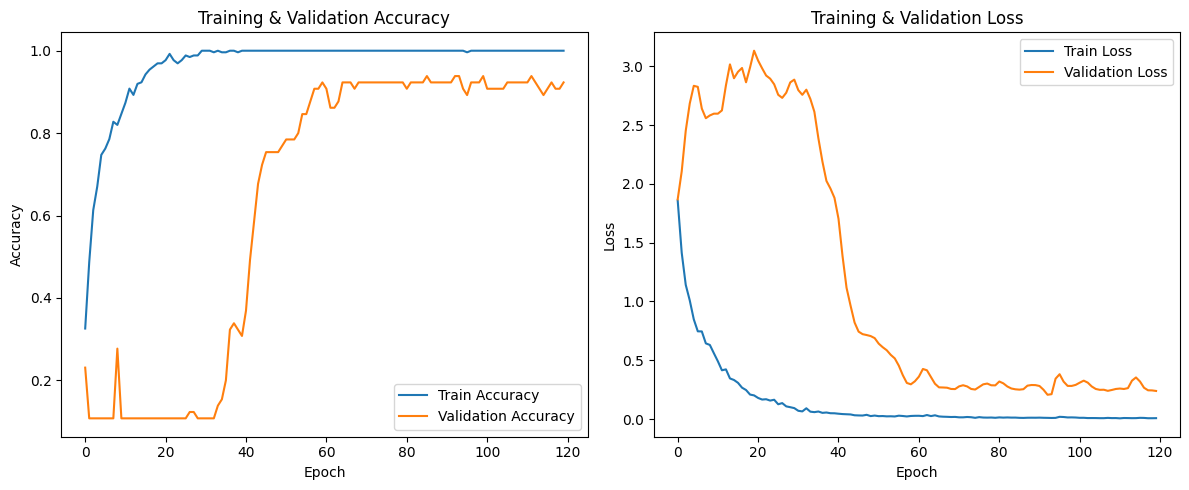

In [34]:
# -------------------------
# 9.4 Learning Curve (Độ chính xác & Độ mất mát)
# -------------------------
plt.figure(figsize=(12, 5))

# Độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Độ mất mát
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
# =========================
# 10. LƯU MÔ HÌNH CUỐI CÙNG
# =========================
final_model_path = '/content/drive/MyDrive/FER_CNN_LSTM/model_final_cnn_lstm.h5'
model.save(final_model_path)
print(f" Mô hình đã được lưu tại: {final_model_path}")


 Mô hình đã được lưu tại: /content/drive/MyDrive/FER_CNN_LSTM/model_final_cnn_lstm.h5
